In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

<IPython.core.display.Javascript object>

In [3]:
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["patch.linewidth"] = 0

sns.set_palette("muted")

<IPython.core.display.Javascript object>

### Data Exploration

In [4]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

<IPython.core.display.Javascript object>

In [5]:
train_df.shape

(42000, 785)

<IPython.core.display.Javascript object>

In [6]:
test_df.shape

(28000, 784)

<IPython.core.display.Javascript object>

In [7]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


<IPython.core.display.Javascript object>

In [9]:
train_df.isna().any(axis=None)

False

<IPython.core.display.Javascript object>

In [10]:
np.min(train_df.values), np.max(train_df.values)

(0, 255)

<IPython.core.display.Javascript object>

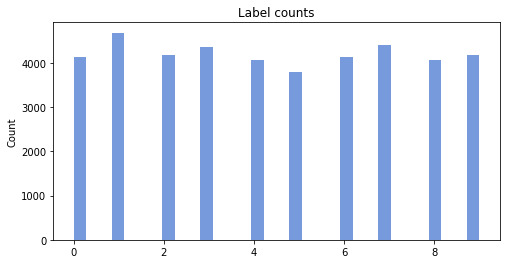

<IPython.core.display.Javascript object>

In [11]:
sns.histplot(data=train_df.label.values)
plt.title("Label counts")
plt.show()

Transform data

In [12]:
target_col = "label"

X_train = (
    train_df.drop(target_col, axis=1)
    .to_numpy(dtype=np.uint8)
    .reshape(train_df.shape[0], 28, 28)
)
Y_train = train_df[target_col].to_numpy(dtype=np.uint8)

X_test = test_df.to_numpy(dtype=np.uint8).reshape(test_df.shape[0], 28, 28)

<IPython.core.display.Javascript object>

In [13]:
X_train.shape

(42000, 28, 28)

<IPython.core.display.Javascript object>

In [14]:
np.min(X_train), np.max(X_train)

(0, 255)

<IPython.core.display.Javascript object>

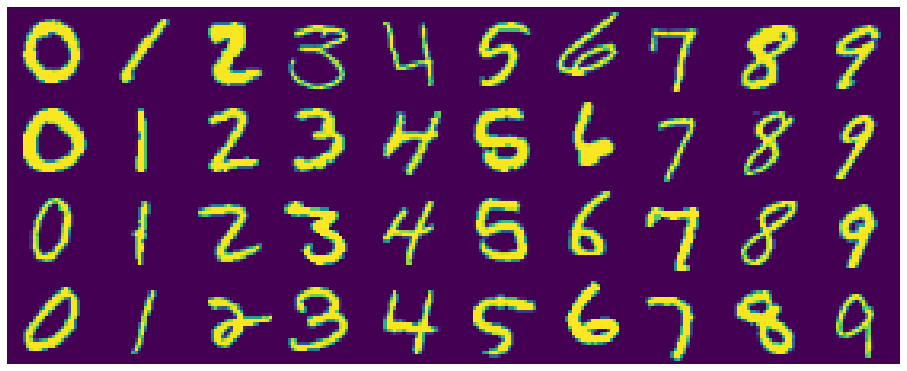

<IPython.core.display.Javascript object>

In [15]:
fig = plt.figure(figsize=(16, 8))

example_digits = np.hstack(
    [X_train[np.nonzero(Y_train == i)][:4].reshape(28 * 4, -1) for i in range(10)]
)
plt.axis("off")
plt.imshow(example_digits)
plt.show()

### Model

In [16]:
import torch
import torch.nn as nn


class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # (b, 1, 28, 28)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(16),
        )
        # (b, 32, 13, 13)
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),
        )
        # (b, 32, 5, 5)
        self.linear = nn.Sequential(
            nn.Linear(800, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
        )
        self.clf = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = self.clf(x)
        return x

<IPython.core.display.Javascript object>

In [17]:
from torchsummary import summary

model = SimpleCNN()
summary(model, (1, 28, 28), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 16, 26, 26]             160
              ReLU-2           [32, 16, 26, 26]               0
         MaxPool2d-3           [32, 16, 13, 13]               0
       BatchNorm2d-4           [32, 16, 13, 13]              32
            Conv2d-5           [32, 32, 11, 11]           4,640
              ReLU-6           [32, 32, 11, 11]               0
         MaxPool2d-7             [32, 32, 5, 5]               0
       BatchNorm2d-8             [32, 32, 5, 5]              64
            Linear-9                  [32, 128]         102,528
             ReLU-10                  [32, 128]               0
      BatchNorm1d-11                  [32, 128]             256
          Dropout-12                  [32, 128]               0
           Linear-13                   [32, 10]           1,290
       LogSoftmax-14                   

<IPython.core.display.Javascript object>

In [18]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

(
    X_train_split, 
    X_val_split, 
    Y_train_split, 
    Y_val_split,
) = train_test_split(X_train, Y_train, train_size=0.7)

train_dataset = TensorDataset(
    torch.tensor(
        (X_train_split.reshape(-1, 1, 28, 28) / 255 * 2) - 1,
        dtype=torch.float32,
    ),
    torch.tensor(Y_train_split),
)

val_dataset = TensorDataset(
    torch.tensor(
        (X_val_split.reshape(-1, 1, 28, 28) / 255 * 2) - 1,
        dtype=torch.float32,
    ),
    torch.tensor(Y_val_split),
)

test_dataset = TensorDataset(
    torch.tensor(
        (X_test.reshape(-1, 1, 28, 28) / 255 * 2) - 1,
        dtype=torch.float32,
    ),
)


<IPython.core.display.Javascript object>

In [19]:
from torch.optim import Adam

loss_f = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)

<IPython.core.display.Javascript object>

In [20]:
from tqdm.notebook import tqdm

batch_size = 32
max_num_epochs = 20
min_delta_acc = 0.001
patience = 3

<IPython.core.display.Javascript object>

In [21]:
%%time

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
)

epoch_losses = [np.nan for _ in range(patience)]
epoch_val_acc = [np.nan for _ in range(patience)]
for epoch_idx in range(max_num_epochs):
    # training
    epoch_loss = 0.0
    for batch_idx, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
        p_hat = model(x)
        loss = loss_f(p_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    # validation
    num_correct = 0
    for batch_idx, (x, y) in tqdm(enumerate(val_loader), total=len(val_loader)):
        p_hat = model(x)
        pred = torch.max(p_hat, 1)[1]        
        num_correct += (y == pred).sum().item()

    val_acc = num_correct / X_val_split.shape[0]
    acc_delta = (val_acc - epoch_val_acc[-1]) / epoch_val_acc[-1]
    print(
        f"Epoch {epoch_idx + 1:>2d}, "
        f"vAcc = {val_acc*100:>6.3f}% ({acc_delta*100:>+6.3f}%), "
        f"Loss = {epoch_loss:.3f}"
    )
    
    # early stopping check
    acc_delta_offset = (val_acc - epoch_val_acc[-patience]) / epoch_val_acc[-patience]
    if abs(acc_delta_offset) < min_delta_acc:
        print(
            f"Validation accuracy over last {patience} iterations improved "
            f"less than min delta {min_delta_acc*100:.2f}%, stopping\n"
        )
        break
    
    epoch_val_acc.append(val_acc)
    epoch_losses.append(epoch_loss)

epoch_val_acc = epoch_val_acc[patience:]
epoch_losses = epoch_losses[patience:]

  0%|          | 0/919 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

Epoch  1, vAcc = 95.254% (  +nan%), Loss = 458.306


  0%|          | 0/919 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

Epoch  2, vAcc = 96.516% (+1.325%), Loss = 153.312


  0%|          | 0/919 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

Epoch  3, vAcc = 97.072% (+0.576%), Loss = 101.674


  0%|          | 0/919 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

Epoch  4, vAcc = 97.603% (+0.548%), Loss = 79.932


  0%|          | 0/919 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

Epoch  5, vAcc = 97.603% (+0.000%), Loss = 62.411


  0%|          | 0/919 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

Epoch  6, vAcc = 97.683% (+0.081%), Loss = 54.702


  0%|          | 0/919 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

Epoch  7, vAcc = 97.841% (+0.162%), Loss = 49.425


  0%|          | 0/919 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

Epoch  8, vAcc = 97.881% (+0.041%), Loss = 42.983


  0%|          | 0/919 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

Epoch  9, vAcc = 98.032% (+0.154%), Loss = 36.340


  0%|          | 0/919 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

Epoch 10, vAcc = 98.167% (+0.138%), Loss = 33.611


  0%|          | 0/919 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

Epoch 11, vAcc = 98.119% (-0.049%), Loss = 31.109


  0%|          | 0/919 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

Epoch 12, vAcc = 98.008% (-0.113%), Loss = 25.428
Validation accuracy over last 3 iterations improved less than min delta 0.10%, stopping

CPU times: user 3min 33s, sys: 28.1 s, total: 4min 1s
Wall time: 4min 24s


<IPython.core.display.Javascript object>

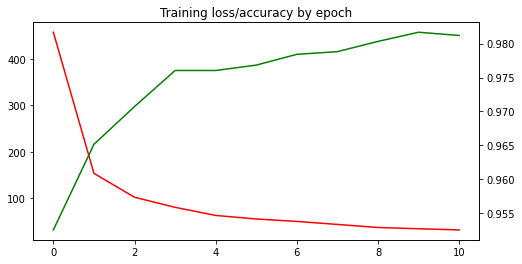

<IPython.core.display.Javascript object>

In [22]:
train_val_acc = np.array(epoch_val_acc)
train_loss = np.array(epoch_losses)

n_samples = train_loss.shape[0]

sns.lineplot(x=np.arange(n_samples), y=train_loss, color="red")
ax = plt.twinx()
sns.lineplot(x=np.arange(n_samples), y=train_val_acc, color="green", ax=ax)
plt.title("Training loss/accuracy by epoch")
plt.show()

In [23]:
torch.save(model.state_dict(), f"mnist_cnn.pt")

<IPython.core.display.Javascript object>

### Predict

In [24]:
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
)

predictions = []

for batch_idx, data in tqdm(enumerate(test_loader), total=len(test_loader)):
    (x,) = data
    p_hat = model(x)

    values, indices = torch.max(p_hat, 1)
    predictions.append(indices.numpy())

  0%|          | 0/875 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [25]:
predictions = np.array(predictions).reshape(-1)

<IPython.core.display.Javascript object>

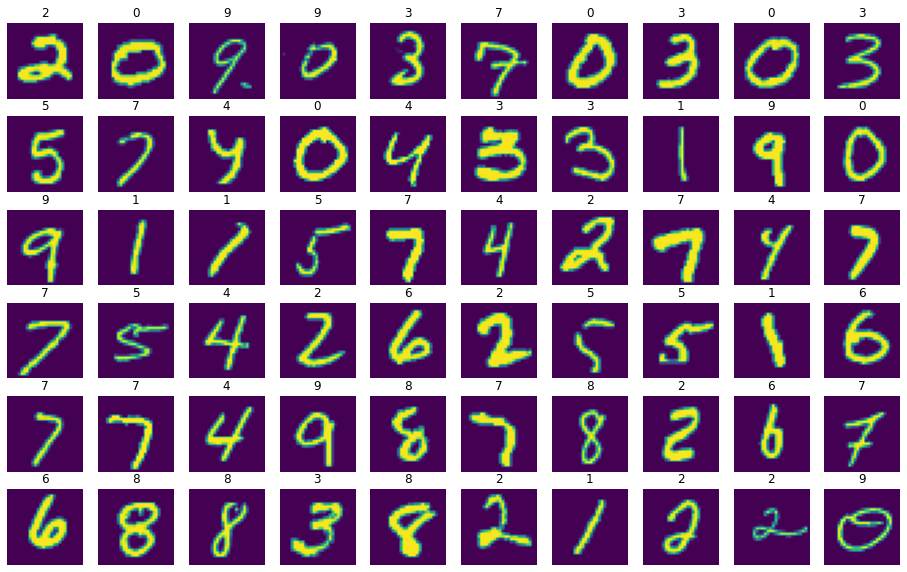

<IPython.core.display.Javascript object>

In [26]:
fig = plt.figure(figsize=(16, 10))

n_rows, n_cols = 6, 10

for i in range(n_rows * n_cols):
    fig.add_subplot(n_rows, n_cols, i + 1)
    plt.imshow(X_test[i])
    plt.axis("off")
    plt.title(predictions[i])

plt.show()

In [27]:
submission_df = (
    pd.DataFrame(predictions, columns=["Label"])
    .reset_index()
    .assign(
        ImageId=lambda df: df["index"] + 1,
    )
    .drop("index", axis=1)
)[["ImageId", "Label"]]
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


<IPython.core.display.Javascript object>

In [28]:
submission_df.to_csv(
    f"data/submission.csv",
    index=False,
)

<IPython.core.display.Javascript object>